In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
from typing import List, Dict, Union
import numpy as np
import torch
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice

from torchmetrics.classification import BinaryPrecisionRecallCurve
from sklearn.metrics import auc

## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur

sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet
from utils import  epoch_average, UMapGenerator
from model.mahalanobis_adatper import (
    get_pooling_mahalanobis_detector, 
    get_batchnorm_mahalanobis_detector
)
from model.wrapper import PoolingMahalanobisWrapper, BatchNormMahalanobisWrapper


from matplotlib.colors import ListedColormap, Normalize

def format_e(n):
    a = '%e' % n
    return a.split('e')[0].rstrip('0').rstrip('.') + 'e' + a.split('e')[1]


# Create a custom colormap - transparent for class 0, and different colors for other classes
seg_colors = ['none', 'yellow', 'green', 'blue']  # 'none' for transparent
err_colors = ['none', 'red']
seg_cmap = ListedColormap(seg_colors)
err_cmap = ListedColormap(err_colors)

# Ensure the colormap is normalized to the number of classes
seg_norm = Normalize(vmin=0, vmax=len(seg_colors)-1)
err_norm = Normalize(vmin=0, vmax=len(err_colors)-1)



nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [5]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [6]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '_all'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])


unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda().eval()

In [47]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = False
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = 'all' #['A'] #
cfg.data.heart.mnm.selection = 'non_empty_target' # 'all_cases' #'non_empty_target'

data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

dataloader = DataLoader(
    data['train'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties

Available datasets are: ['train', 'A', 'B', 'C', 'D']


In [8]:
class UMapGenerator(nn.Module):
    """
    Calculates uncertainty maps from UNets in different ways.
    
    PyTorch Module to generate uncertainty maps from
    * VAE samples
    * Entropy in drop out samples
    * Entropy in model outputs
    """
    
    def __init__(
        self,
        method: str,  # 'ae'
        net_out: str,  # 'mms' or 'calgary'
    ):
        super().__init__()
        self.method  = method
        self.net_out = net_out
        self.m       = nn.Softmax(dim=1) if net_out=='heart' else nn.Sigmoid()
        self.ce      = nn.CrossEntropyLoss(reduction='none') if net_out=='heart' else nn.BCEWithLogitsLoss(reduction='none')
        self.kld     = nn.KLDivLoss(reduction='none')
        self.mse     = nn.MSELoss(reduction='none')

        assert net_out in ['heart', 'brain'], f"Unknown net_out: {net_out}"
    
    @torch.no_grad()
    def forward(
        self, 
        x: Tensor, 
        batch_size: int = 1
    ) -> Tensor:
        
        if self.method == 'none':
            return None
        
        x = x.detach()
        umap_numerator = None
        umap_denominator = None
        #################################
        ### Cross and regular Entropy ###
        #################################

        if self.method == 'cross_entropy':
            umap = self.ce(x[:batch_size], self.m(x[batch_size:]))
            if len(umap.shape) == 3:
                umap = umap.unsqueeze(1)
            # umap = umap.mean(dim=1, keepdims=True)
            
        elif self.method == 'entropy':          
            x_prob = self.m(x[:batch_size])
            umap = torch.special.entr(x_prob).sum(dim=1, keepdims=True)
            # umap = torch.distributions.Categorical(x_prob.permute(0,2,3,1)).entropy().unsqueeze(1)

        elif self.method == 'top2diff':
            x_prob = self.m(x[:batch_size])
            assert len(x_prob.shape) == 4, f"x_prob shape is {x_prob.shape}, but should be (n, c, h, w)"
            x_prob_sorted, _ = x_prob.sort(1)
            umap = 1 - (x_prob_sorted[:, -1:] - x_prob_sorted[:, -2:-1])
            assert len(umap.shape) == 4, f"umap shape is {umap.shape}, but should be (n, 1, h, w)"

        elif self.method == 'top2diff_diff':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            output_prob_sorted, _ = output_prob.sort(1)
            output_augmented_prob_sorted, _ = output_augmented_prob.sort(1)
            umap = (output_prob_sorted[:, -1:] - output_prob_sorted[:, -2:-1]) - \
                   (output_augmented_prob_sorted[:, -1:] - output_augmented_prob_sorted[:, -2:-1])

        elif self.method == 'kld_entr':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            output_augmented_log_prob = torch.log(output_augmented_prob + 1e7)
            # output_augmented_prob = self.m(x[batch_size:])
            entropy = torch.special.entr(output_prob).sum(dim=1, keepdims=True)
            # print(f'entropy: {entropy.shape} {entropy.mean()}')
            kld = self.kld(output_augmented_log_prob, output_prob).sum(dim=1, keepdims=True)
            # print(f'kld: {kld.shape} {kld.mean()}')
            umap = entropy * kld

        elif self.method == 'mse_entr':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            output_augmented_log_prob = torch.log(output_augmented_prob + 1e7)
            # output_augmented_prob = self.m(x[batch_size:])
            entropy = torch.special.entr(output_prob).sum(dim=1, keepdims=True)
            # print(f'entropy: {entropy.shape} {entropy.mean()}')
            mse = self.mse(output_prob, output_augmented_prob).mean(dim=1, keepdims=True)
            # print(f'kld: {kld.shape} {kld.mean()}')
            umap = entropy * mse

        elif self.method == 'centr_entr':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            entropy = torch.special.entr(output_prob).sum(dim=1, keepdims=True)
            ce = self.ce(output_prob, output_augmented_prob).unsqueeze(1)#.sum(dim=1, keepdims=True)
            umap = entropy * ce

        elif self.method == 'diff_grad':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            predicted_class_prob, index_of_class = output_prob.max(dim=1, keepdim=True)
            diff_to_pred = predicted_class_prob - output_prob
            diff_to_pred_augmented = torch.gather(output_augmented_prob, 1, index_of_class) - output_augmented_prob
            umap = (diff_to_pred - diff_to_pred_augmented) / (diff_to_pred + 1e-9) #torch.max(diff_to_pred, torch.ones_like(diff_to_pred) * 1e-7)
            umap[diff_to_pred <= 0] = 0
            # umap[umap < 0] = 0
            umap_argmax = torch.argmax(umap, dim=1, keepdim=True)
            umap = torch.amax(umap, dim=1, keepdim=True)
            # print(umap_argmax.shape)
            umap_argmax_onehot = F.one_hot(umap_argmax.squeeze(1), num_classes=4).permute(0,3,1,2)
            # print(umap_argmax_onehot.shape)

            umap_numerator = ((diff_to_pred - diff_to_pred_augmented) *  umap_argmax_onehot).sum((1)).squeeze() #[umap_argmax.squeeze(), torch.arange(256), torch.arange(256)]
            # print(umap_numerator.shape)
            # diff_to_pred[diff_to_pred==0] = 1
            umap_denominator = (umap_argmax_onehot / (diff_to_pred.squeeze() + 1e-9)).sum((1)).squeeze() #(diff_to_pred.squeeze()[umap_argmax.squeeze(), torch.arange(256), torch.arange(256)] + 1e-9)
            # print(umap_denominator.shape)

        elif self.method == 'top2_grad':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            predicted_class_prob, index_of_class = output_prob.max(dim=1, keepdim=True)
            diff_to_pred = predicted_class_prob - output_prob
            _, prob_magnitude_indices = diff_to_pred.sort(1)
            # print('indices', prob_magnitude_indices.shape)
            second_highest_prob_index = prob_magnitude_indices[:, -2:-1]
            # print('index', second_highest_prob_index.shape)
            diff_to_pred_augmented = torch.gather(output_augmented_prob, 1, index_of_class) - output_augmented_prob
            umap = diff_to_pred - diff_to_pred_augmented
            # print('umap', umap.shape)
            umap = torch.gather(umap, 1, second_highest_prob_index)
            # print('top2 umap', umap.shape)
            umap[umap < 0] = 0

        elif self.method == 'entr_grad':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            output_entrp = torch.special.entr(output_prob).sum(dim=1, keepdims=True)
            output_augmented_entrp = torch.special.entr(output_augmented_prob).sum(dim=1, keepdims=True)

            umap = output_augmented_entrp - output_entrp
            # print('entrp umap', umap.shape)
            umap[umap < 0] = 0

        
        assert umap.shape[1] == 1, f"umap shape is {umap.shape}, but should be (n, 1, h, w)"
        assert not torch.isnan(umap).any(), f"umap contains nan values"
        return umap, umap_numerator, umap_denominator

In [23]:
dataloader = DataLoader(data['train'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]
sequential = False


detector = get_pooling_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    pool='none',
    sigma_algorithm='diagonal',
    fit='raw',
    dist_fn='squared_mahalanobis',
    iid_data=dataloader,
    transform=True,
    lr=1e-4,
    sequential=sequential,
    device='cuda:0'
)



### 1. get all UMapGenerators I want to test
- entropy
- original margin/gap
- only margin

In [24]:
# specify output
net_out = 'heart'


# regular entropy
entrp_gen = UMapGenerator(
    method='entropy',
    net_out=net_out,
)

# margin between two most likely classes
top2_grad_gen = UMapGenerator(
    method='top2_grad',
    net_out=net_out,
)

# old diff grad
diff_grad_gen = UMapGenerator(
    method='diff_grad',
    net_out=net_out,
)

# gather in dict
umap_generators = {
    'entropy': entrp_gen,
    'top2_grad': top2_grad_gen,
    'diff_grad': diff_grad_gen,
}

### 2. define the eval functions
- get umaps for everything
- combine and normalize, extent original dict
- get additional information: errmaps, image ids, DSCs



In [25]:
def get_all_umaps(
    model: nn.Module,
    umap_generators: Dict[str, UMapGenerator],
    dataloader: DataLoader,
) -> Dict:
    model.eval()

    errmaps_collection, DSCs, img_indices = [], [], []
    umaps_collection  = {}
    

    # saves batch sizes for each batch for averaging
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target'].long()
        img_indices.append(batch['index'])
        # convert -1 labels to background
        target[target == -1] = 0
        # get model output
        model.set_transform(False)
        output_original = model(input_.cuda()).detach()
        model.set_transform(True)
        output_transformed = model(input_.cuda()).detach()
        # net_out = model(input_.cuda()).detach().cpu()
        segmap = torch.argmax(output_original, dim=1, keepdims=True)
        errmaps = (target != segmap).long()
        errmaps_collection.append(errmaps)
        DSCs.append(
            torch.tensor([dice(
                    s.flatten(), 
                    t.flatten(),
                    num_classes=4,
                    zero_division=1,
                    average='macro'
                ) for s,t in zip(segmap, target)]
            ).cpu()
        )

        for i, key in enumerate(umap_generators):
            umaps, _, _ = umap_generators[key](
                torch.cat([output_original, output_transformed], dim=0),
                batch_size=input_.shape[0]
            )
            
            umaps_collection.setdefault(key, []).append(umaps.detach().clone())
             
             
    return torch.cat(DSCs), umaps_collection, torch.cat(img_indices), errmaps_collection



def eval_heart_set(
    model: nn.Module,
    umap_generators: Dict[str, UMapGenerator],
    dataloader: DataLoader,
) -> Dict:
    model.eval()

    DSCs, img_indices = [], []
    pr_aucs = {}
    
    bprc = BinaryPrecisionRecallCurve(thresholds = None).cuda()
    for key in umap_generators:
        print(key)
    # saves batch sizes for each batch for averaging
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target'].long()
        img_indices.append(batch['index'])
        # convert -1 labels to background
        target[target == -1] = 0
        # # convert to one-hot encoding
        # target = F.one_hot(
        #     target.long(), 
        #     num_classes=4
        # ).squeeze(1).permute(0,3,1,2)
        # get model output
        model.set_transform(False)
        output_original = model(input_.cuda()).detach()
        model.set_transform(True)
        output_transformed = model(input_.cuda()).detach()
        # net_out = model(input_.cuda()).detach().cpu()
        segmap = torch.argmax(output_original, dim=1, keepdims=True)
        errmaps = (target != segmap).long()
        DSCs.append(
            torch.tensor([dice(
                    s.flatten(), 
                    t.flatten(),
                    num_classes=4,
                    zero_division=1,
                    average='macro'
                ) for s,t in zip(segmap, target)]
            ).cpu()
        )

        for i, key in enumerate(umap_generators):
            umaps, umap_numerator, umap_denominator = umap_generators[key](
                torch.cat([output_original, output_transformed], dim=0),
                batch_size=input_.shape[0]
            )
            # print(umaps.min(), umaps.max())
            umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
            if i == 0:
                umaps_out = umaps.clone()
            else:
                umaps_out = (umaps_out + umaps) / 2
                # umaps_out = (umaps_out - umaps_out.min()) / (umaps_out.max() - umaps_out.min())
            # print(umaps.min(), umaps.max(), umaps.max() - umaps.min())

            # print(umaps.shape, errmaps.shape)
            for umap, errmap in zip(umaps_out, errmaps):
                pr = bprc(umap.cpu(), errmap.cpu())
                # print(pr[0].shape)
            # print(pr[0].shape)
            # for pr1, pr0 in zip(pr[1], pr[0]):
                pr_aucs.setdefault(key, []).append(auc(pr[1], pr[0]))

        # break
             
             
    return torch.cat(DSCs), pr_aucs, torch.cat(img_indices)


def eval_heart_entropy(
    model: nn.Module,
    umap_generator: UMapGenerator,
    dataloader: DataLoader,
) -> Dict:
    model.eval()

    errmaps_collection, DSCs, img_indices = [], [], []
    umaps_collection = []
    batch_size = 32

    # saves batch sizes for each batch for averaging
    for batch in dataloader:
        input_ = batch['input'].cuda()
        target = batch['target'].cuda()
        img_indices.append(batch['index'])
        # convert -1 labels to background
        target[target == -1] = 0
        # # convert to one-hot encoding
        # target = F.one_hot(
        #     target.long(), 
        #     num_classes=4
        # ).squeeze(1).permute(0,3,1,2)
        # get model output
        # model.set_transform(False)
        output = model(input_).detach()
        # model.set_transform(True)
        # output_transformed = model(input_.cuda()).detach()
        # net_out = model(input_.cuda()).detach().cpu()
        segmap = torch.argmax(output[:batch_size], dim=1, keepdims=True)
        errmaps = (target != segmap).float()
        errmaps_collection.append(errmaps.cpu())
        # DSCs.append(
        #     torch.tensor([dice(
        #             s.flatten(), 
        #             t.flatten(),
        #             num_classes=4,
        #             zero_division=1,
        #             average='macro'
        #         ) for s,t in zip(segmap, target.long())]
        #     ).cpu()
        # )

       
        # umaps, umap_numerator, umap_denominator = umap_generator(
        #     output,
        #     batch_size=input_.shape[0]
        # )

        # umaps = umap_generator(
        #     output,
        #     batch_size=32
        # )

        umaps_collection.append(
            umap_generator(
                output,
                batch_size=32
            ).cpu()
        )

    umaps = torch.cat(umaps_collection).flatten()
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps_collection).flatten().to(torch.uint8)

    taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).cpu()
    print(umaps.shape, errmaps.shape)
    pr = bprc(umaps.cpu(), errmaps.cpu())
            # print(umaps.min(), umaps.max())
            # umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
            # if i == 0:
            #     umaps_out = umaps.clone()
            # else:
            #     umaps_out = (umaps_out + umaps) / 2
            #     # umaps_out = (umaps_out - umaps_out.min()) / (umaps_out.max() - umaps_out.min())
            # # print(umaps.min(), umaps.max(), umaps.max() - umaps.min())

            # # print(umaps.shape, errmaps.shape)
            # for umap, errmap in zip(umaps_out, errmaps):
            #     pr = bprc(umap.cpu(), errmap.cpu())
            #     # print(pr[0].shape)
            # # print(pr[0].shape)
            # # for pr1, pr0 in zip(pr[1], pr[0]):
            #     pr_aucs.setdefault(key, []).append(auc(pr[1], pr[0]))

        # break
             
             
    return auc(pr[1], pr[0])


def get_precision_recall(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str, 
    dae: bool,
    umap: str,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):

    model.eval()
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        gt = batch['target'].to(device[0])
        gt[gt == -1] = 0
        output = model(input_).detach()


        segmap = torch.argmax(output[:batch_size], dim=1, keepdims=True)
        errmap = (gt != segmap).float()
        umaps.append(umap_generator(output, batch_size=batch_size).cpu())
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps).flatten() #.half()
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)

    # in case of manual threshold selection
    # if n_taus != 'auto':
    #     # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
    #     taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    # elif n_taus == 'auto':
    taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    print(umaps.shape, errmaps.shape)
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))

    return auc(pr[1], pr[0])
    # if device[1] != 'cpu':
    #     pr = tuple(map(lambda x: x.cpu(), pr))

    # pr_auc = auc(pr[1], pr[0])

    # # subset precision/recall to 100 points for plotting
    # # we find indices along the x axis (recall) such that they
    # # have roughly equal distance to each other and select the 
    # # corresponding y values (precision)
    # p, r, _= pr  
    # # find indices for sorting in recall
    # indices = np.argsort(r)
    # # sort precision and recall similarly
    # r_sorted, p_sorted = (r[indices], p[indices])
    # # select target values for recall
    # target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # # find best matches in sorted recall, that are smaller or equal to the target values
    # subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # # select precision and recall at the best matches
    # r_sampled, p_sampled = (
    #     r_sorted[subset_indices], 
    #     p_sorted[subset_indices]
    # )

    # return p_sampled, r_sampled, pr_auc

In [83]:
test_site = 'A'

testloader = DataLoader(
    data[test_site], 
    batch_size=32, 
    shuffle=False, 
    drop_last=True
)


DSCs, umaps_collection, img_indices, errmaps_collection = get_all_umaps(
    model=detector,
    umap_generators=umap_generators,
    dataloader=testloader
)


In [84]:
# normalize all umaps to [0,1] and clamp to 99th percentile
umaps = {key: torch.cat(umaps_collection[key]).flatten() for key in umaps_collection}
for key in umaps:
    # clamp to 99th percentile
    if key != 'entropy':
        q = np.percentile(umaps[key].flatten().numpy(), 99.9999)
        print(umaps[key].min(), umaps[key].max(), q, key)
        umaps[key][umaps[key] > q] = q

        # umaps[key] = torch.sqrt(umaps[key])
    # q = np.percentile(umaps[key].flatten().numpy(), 99)
    # umaps[key][umaps[key] > q] = q
    # normalize to [0,1]
    
    min_ = umaps[key].min()
    max_ = umaps[key].max()
    umaps[key] = (umaps[key] - min_) / (max_ - min_)

    if key == 'entropy':
        center = 0.7
    elif key == 'top2_grad':
        center = 0.2
    umaps[key] = torch.sigmoid(umaps[key] - center)

# convert errormaps to tensors as well
errmaps = torch.cat(errmaps_collection).flatten().to(torch.uint8).to(torch.uint8)

# add umap combinations
keys = list(umaps.keys())
for key in keys:
    if key == 'entropy':
        continue
    umaps[key + '_entropy'] = (umaps[key] + umaps['entropy']) / 2

print(umaps.keys())

tensor(0.) tensor(0.0209) 0.010839838138021918 top2_grad
tensor(0.) tensor(1882.5652) 13.931145913835536 diff_grad
dict_keys(['entropy', 'top2_grad', 'diff_grad', 'top2_grad_entropy', 'diff_grad_entropy'])


### 3. evaluate UMaps
- per pixel for each score

In [85]:
prs = {}
pr_aucs = {}
bprc = BinaryPrecisionRecallCurve(thresholds = None).cpu()

for key in umaps:
    if key in ['diff_grad', 'diff_grad_entropy']:
        continue
    print(key)
    # bprc = BinaryPrecisionRecallCurve(thresholds = np.quantile(umaps[key], torch.linspace(0, 1, 100)).tolist()).cpu()
    pr = bprc(umaps[key].cpu(), errmaps.cpu())
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    prs.setdefault(key, []).append([p_sampled, r_sampled])
    # prs.setdefault(key, []).append([pr[0], pr[1]])
    pr_aucs.setdefault(key, []).append(auc(pr[1], pr[0]))

entropy
top2_grad
top2_grad_entropy


entropy: [0.3976868689060211]
top2_grad: [0.24556513130664825]
top2_grad_entropy: [0.4102177023887634]


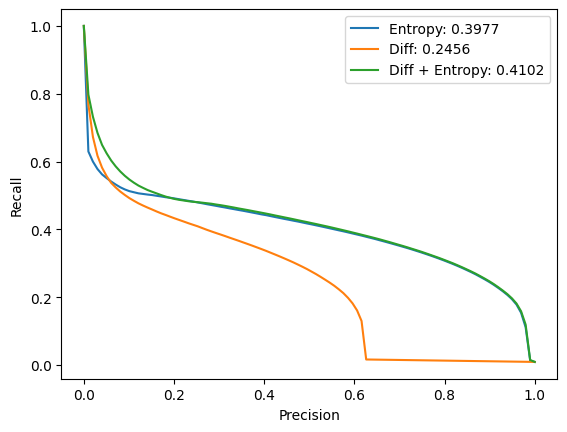

In [86]:
label_dict = {
    'entropy': 'Entropy',
    'top2_grad': 'Diff',
    'diff_grad': 'Diff / Margin',
    'diff_grad_entropy': 'Diff / Margin + Entropy',
    'top2_grad_entropy': 'Diff + Entropy',
}

for key in pr_aucs:
    if key in ['diff_grad', 'diff_grad_entropy']:
        continue
    label = label_dict[key]


    print(f'{key}: {pr_aucs[key]}')
    plt.plot(prs[key][0][1], prs[key][0][0], label=f'{label}: {pr_aucs[key][0]:.4f}')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

plt.legend()


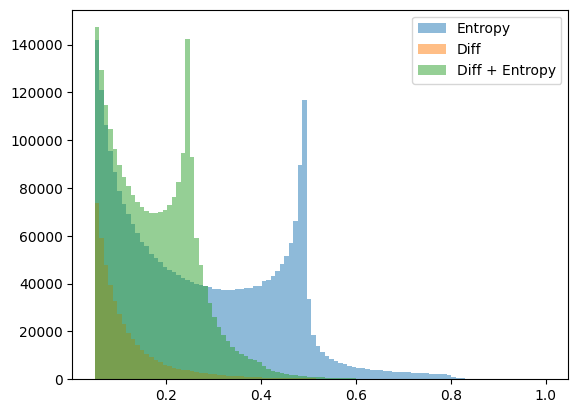

In [87]:
for key in umaps:
    if key in ['diff_grad', 'diff_grad_entropy']:
        continue
    label = label_dict[key]
    um = (umaps[key] - umaps[key].min()) / (umaps[key].max() - umaps[key].min())
    # plt.hist(umaps[key][umaps[key]>0.05], bins=100, alpha=0.5, label=label, )
    plt.hist(um[um>0.05], bins=100, alpha=0.5, label=label, )
    # plt.yscale('log')
    # hist = torch.histogram(umaps[key][umaps[key]>0.05], bins=100)
    # plt.plot(hist[1][:-1], hist[0], label=key)
plt.legend()

In [79]:
umaps[key].min()

tensor(0.3318)

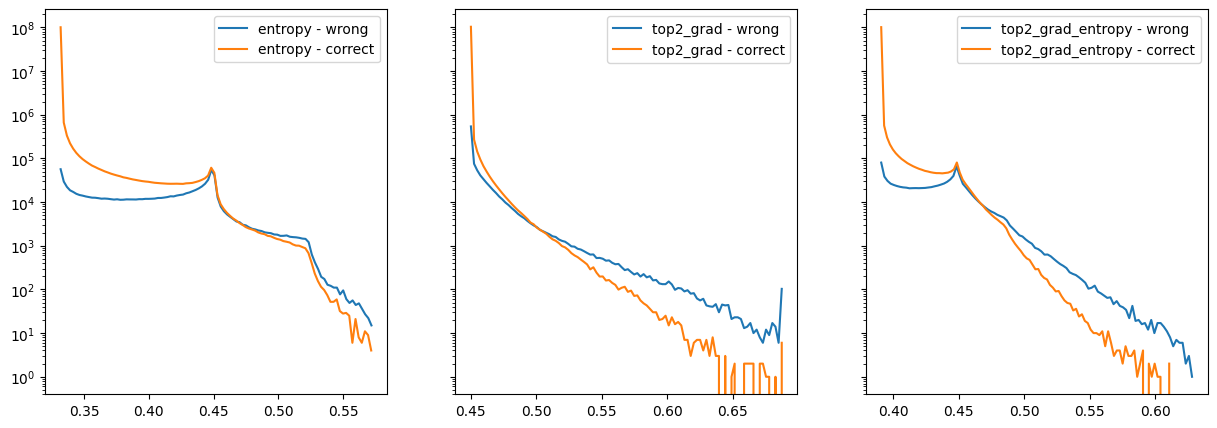

In [88]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

i = 0
for key in umaps:
    if key in ['diff_grad', 'diff_grad_entropy']:
        continue
    label = label_dict[key]
    # plt.hist(umaps[key][errmaps == 1], bins=100, alpha=0.5, label=label, )
    hist = torch.histogram(umaps[key][errmaps == 1], bins=100)
    axes[i].plot(hist[1][:-1], hist[0], label=f'{key} - wrong')
    hist = torch.histogram(umaps[key][errmaps == 0], bins=100)
    axes[i].plot(hist[1][:-1], hist[0], label=f'{key} - correct')
    axes[i].set_yscale('log')
    axes[i].legend()
    # hist = torch.histogram(umaps[key][umaps[key]>0.05], bins=100)
    # plt.plot(hist[1][:-1], hist[0], label=key)
    # plt.legend()
    # plt.title('UMap Histograms - Error Pixels')
    # plt.show()

    i+=1


Text(0.5, 1.0, 'UMap Histograms - Correct Pixels')

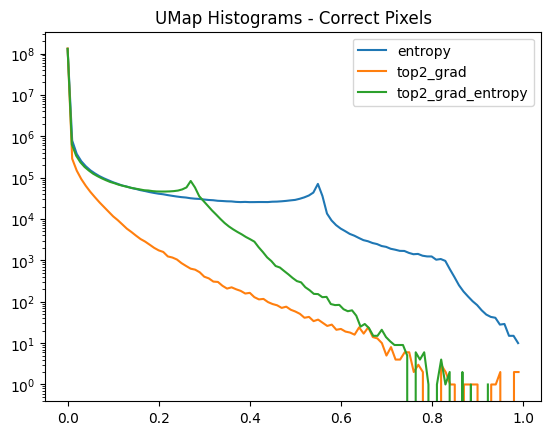

In [66]:
for key in umaps:
    if key in ['diff_grad', 'diff_grad_entropy']:
        continue
    label = label_dict[key]
    # plt.hist(umaps[key][errmaps == 1], bins=100, alpha=0.5, label=label, )
    # plt.yscale('log')
    hist = torch.histogram(umaps[key][errmaps == 0], bins=100)
    plt.plot(hist[1][:-1], hist[0], label=key)
    plt.yscale('log')
plt.legend()
plt.title('UMap Histograms - Correct Pixels')

In [13]:
umaps_collection_copy = {key: torch.cat(umaps_collection[key]).flatten() for key in umaps_collection}
for key in umaps_collection_copy:
    if key != 'entropy':
        q = np.percentile(umaps_collection_copy[key].flatten().numpy(), 99)
        umaps_collection_copy[key][umaps_collection_copy[key] > q] = q

    min_ = umaps_collection_copy[key].min()
    max_ = umaps_collection_copy[key].max()
    umaps_collection_copy[key] = (umaps_collection_copy[key] - min_) / (max_ - min_)

errmaps_collection_copy = torch.cat(errmaps_collection).flatten().to(torch.uint8)

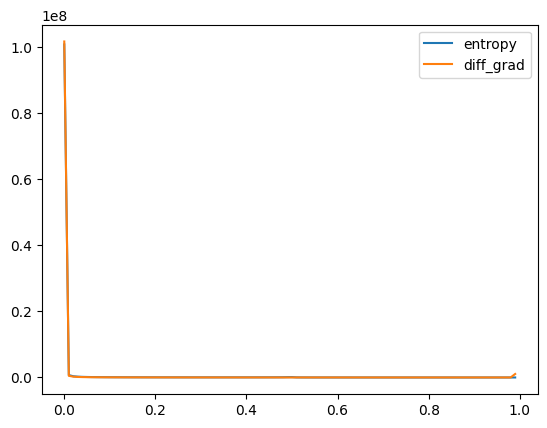

In [14]:
for key in umaps_collection_copy:
    hist = torch.histogram(umaps_collection_copy[key])
    plt.plot(hist[1][:-1], hist[0], label=key)

plt.legend()

In [15]:

prs = {}
pr_aucs = {}
bprc = BinaryPrecisionRecallCurve(thresholds = None).cpu()


for key in umaps_collection_copy:
    # if key != 'entropy':
    #     continue
    print(key)
    pr = bprc(umaps_collection_copy[key].cpu(), errmaps_collection_copy.cpu())
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    prs.setdefault(key, []).append([p_sampled, r_sampled])
    pr_aucs.setdefault(key, []).append(auc(pr[1], pr[0]))

key = 'entr_grad_combi'
umap = (umaps_collection_copy['entropy'] + umaps_collection_copy['diff_grad']) / 2
pr = bprc(umap.cpu().flatten(), errmaps_collection_copy.cpu().flatten().to(torch.uint8))
p, r, _= pr  
# find indices for sorting in recall
indices = np.argsort(r)
# sort precision and recall similarly
r_sorted, p_sorted = (r[indices], p[indices])
# select target values for recall
target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
# find best matches in sorted recall, that are smaller or equal to the target values
subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
# select precision and recall at the best matches
r_sampled, p_sampled = (
    r_sorted[subset_indices], 
    p_sorted[subset_indices]
)

prs.setdefault(key, []).append([p_sampled, r_sampled])

prs.setdefault(key, []).append(pr)
pr_aucs.setdefault(key, []).append(auc(pr[1], pr[0]))

entropy
diff_grad


entropy: [0.39761263132095337]
diff_grad: [0.3423360586166382]
entr_grad_combi: [0.37442898750305176]


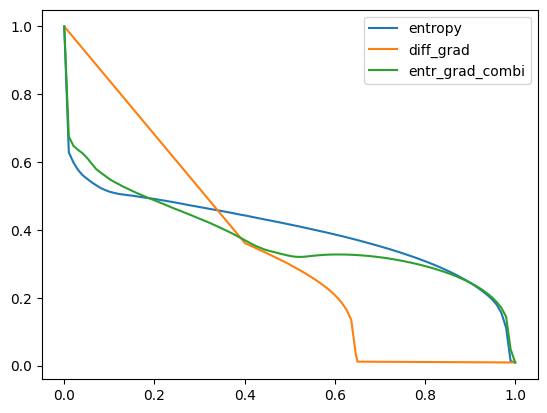

In [16]:
for key in pr_aucs:
    print(f'{key}: {pr_aucs[key]}')
    plt.plot(prs[key][0][1], prs[key][0][0], label=f'{key}')

plt.legend()

# for key in pr_aucs:
#     print(f'{key}: {pr_aucs[key]}')
#     plt.plot(prs[key][0][1][10::1000], prs[key][0][0][10::1000], label=f'{key}')

# plt.legend()

entropy: [0.39761263132095337]
diff_grad: [0.3423360586166382]
entr_grad_combi: [0.37442898750305176]


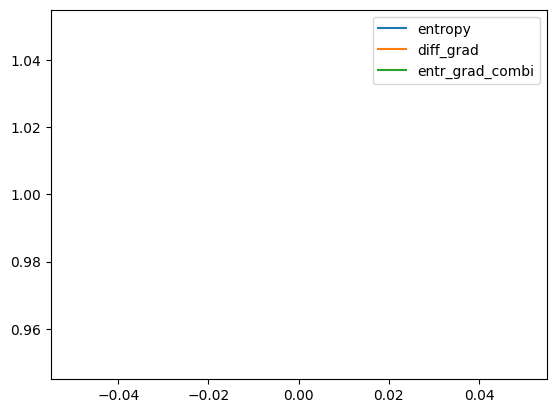

In [17]:
for key in pr_aucs:
    print(f'{key}: {pr_aucs[key]}')
    plt.plot(prs[key][0][1][::10000], prs[key][0][0][::10000], label=f'{key}')

plt.legend()

In [18]:
DSCs, pr_aucs, img_indices = eval_heart_set(
    model=detector,
    umap_generators=umap_generators,
    dataloader=testloader
)

pr_aucs_working = pr_aucs.copy()


entropy
diff_grad


In [23]:
for key in pr_aucs_working:
    pr_aucs_working[key] = torch.tensor(pr_aucs_working[key])[~torch.isnan(torch.tensor(pr_aucs_working[key]))]

In [24]:

for key in pr_aucs_working:
    pr_aucs_working[key] = torch.tensor(pr_aucs_working[key])
    print(f'{key}: {pr_aucs_working[key].mean()}')


entropy: 0.4185937810434054
diff_grad: 0.4188958688814235


/tmp/ipykernel_1262768/1622238460.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pr_aucs_working[key] = torch.tensor(pr_aucs_working[key])


In [25]:
torch.stack([pr_aucs_working['entropy'], pr_aucs_working['diff_grad']]).amax(0).mean()

tensor(0.4194, dtype=torch.float64)